In [145]:
import numpy as np
from scipy.sparse import diags
import math
from scipy import special
import matplotlib.pyplot as plt
from functools import cache
import mpmath as mp
from decimal import *
from scipy.interpolate import make_interp_spline
import jax.numpy as jnp
from jax import random
import jax

jax.config.update("jax_enable_x64", True)

seed= 9898
key = random.key(seed)

# Parameters
a = -6
b = 2

num_trials = 1000
num_samples = 10000000


N=690
beta = 4

In [146]:
@jax.jit
def tridiagdet(main, off):
    n = len(main)
    l = jnp.array([0,1],dtype=jnp.float64)
    
    def body(i,l):
        l = jnp.array([l[-1], main[i]*l[-1]- off[i-1]**2*l[-2]], dtype=jnp.float64)
        return l
    
    return jax.lax.fori_loop(0, n, body, l)[-1]

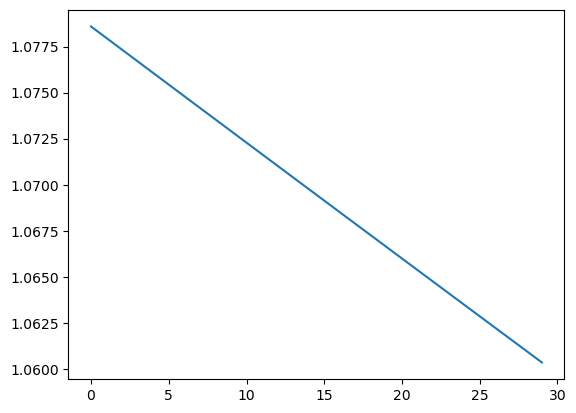

In [168]:
def w1(z,N,n):
    return 1/(jnp.power(2*math.pi,1/4)*jnp.exp(N*jnp.power(z,2))*jnp.power(jnp.float64(2),-n)*jnp.power(N*jnp.power(z,2),-1/12)*jnp.sqrt(jax.scipy.special.factorial(n)/(jnp.power(N,n))))

def w2(z,N):
    return 1/(jnp.power(2*math.pi, 1/(4*N))*jnp.exp(jnp.power(z,2))*(1/2)*jnp.power(N*jnp.power(z,2),-1/(12*N))*jnp.power(2*math.pi*N,1/(4*N))*jnp.exp(-1/2))

lam = 0.2

N=10000

_lambda = np.linspace(a,b,30)

plt.plot(w2(1 + _lambda/(2*N**(2/3)),10))
#plt.plot(jnp.power(w1(1 + _lambda/(2*N**(2/3)),N,N), 1/N))

In [173]:
# Correct
"""def GBE(N, key):

    new_key, subkey = random.split(key)
    del key 
    b = math.sqrt(2)*random.normal(subkey,shape=(N), dtype=jnp.float64)
    a = jnp.sqrt(random.chisquare(subkey, df=jnp.array([beta*i for i in range(1,N+1)]), dtype=jnp.float64))
    del subkey
    key = new_key
    return b, a, key 

"""

# Numpy Version
def GBE(N):
    b = math.sqrt(2)*np.random.normal(size=N)
    a = np.array(np.sqrt( np.random.chisquare([beta*i for i in range(1,N+1)])) )
    return jnp.array(b), jnp.array(a)




# Correct
def w(z,N,n):
    return 1/(jnp.power(2*math.pi,1/4)*jnp.exp(N*jnp.power(z,2))*jnp.power(jnp.float64(2),-n)*jnp.power(N*jnp.power(z,2),-1/12)*jnp.sqrt(jax.scipy.special.factorial(n)/(jnp.power(N,n))))

def psi(z,N):
    return jnp.array([tridiagdet(-((4*N*beta)**(-1/2))*w2(z,N)*tridiag_b[0:N]+x,-((4*N*beta)**(-1/2))*w2(z,N)*tridiag_a[0:N]) for x in z], dtype=jnp.float64)

psi(1 + _lambda/(2*N**(2/3)),10)

# Correct
@jax.jit
def phi1(z,N):
    return jnp.array([tridiagdet(-((4*N*beta)**(-1/2))*tridiag_b[0:1]+x,-((4*N*beta)**(-1/2))*tridiag_a[0:1]) for x in z], dtype=jnp.float64)
@jax.jit
def phi2(z,N):
    return jnp.array([tridiagdet(-((4*N*beta)**(-1/2))*tridiag_b[0:2]+x,-((4*N*beta)**(-1/2))*tridiag_a[0:2]) for x in z], dtype=jnp.float64)
@jax.jit
def psi1(l,N):
    return w(1+l/(2*N**(2/3)),N,1)*phi1(1+l/(2*N**(2/3)),N)
@jax.jit
def psi2(l,N):
    return w(1+l/(2*N**(2/3)),N,2)*phi2(1+l/(2*N**(2/3)),N)

@jax.jit
def psi_recurrence(l,N, tridiag_b, tridiag_a):
    
    psi_prev= (psi1(l,N), psi2(l,N))
    
    z = 1 + l/(2*N**(2/3))
    
    
    def body(k, psi_prev):
        X = tridiag_b[k-1]/jnp.sqrt(2)
        Y = (tridiag_a[k-2]**2 - jnp.float64((beta*(k-1))))/jnp.sqrt(2*beta*(k-1))
        
        return ((psi_prev[-1], 
                2*psi_prev[-1] - psi_prev[-2]                                             \
                + (2*(z*jnp.sqrt(N/k)-1-X/jnp.sqrt(2*k*beta)))*psi_prev[-1]  \
                - (Y*jnp.sqrt(2)/jnp.sqrt(beta*k)+jnp.sqrt((k-1)/k)-1)*psi_prev[-2]))
                
    return jax.lax.fori_loop(3, N+1, body, psi_prev)[-1]

TypeError: mul got incompatible shapes for broadcasting: (30,), (10,).

In [4]:
%%time

samples = []
samples_third = []
samples_fourth = []
_lambda = np.linspace(a,b,30)

for trial in range(num_trials):
    sample_paths_var2 = None
    sample_paths_var = None
    sample_paths_third = None
    sample_paths_fourth = None
    
    for i in range(num_samples):
        tridiag_b, tridiag_a = GBE(N)
        path = psi_recurrence(jnp.array(_lambda), N, tridiag_b, tridiag_a)

        if sample_paths_var is None:
            sample_paths_var = path**2
        else:
            sample_paths_var = (i-1)/i*sample_paths_var +  (1)/i*(path**2)

        if sample_paths_third is None:
            sample_paths_third = path**3
        else:
            sample_paths_third = (i-1)/i*sample_paths_third +  (1)/i*(path**3)

        if sample_paths_fourth is None:
            sample_paths_fourth = path**4
        else:
            sample_paths_fourth = (i-1)/i*sample_paths_fourth +  (1)/i*(path**4)
    
    samples.append(sample_paths_var)
    samples_third.append(sample_paths_third)
    samples_fourth.append(sample_paths_fourth)
    #plot_variance(trial)
    #plot_third(trial)
    plot_fourth(trial)

#plot_variance(num_trials)
#plot_third(num_trials)
plot_fourth(num_trials)

KeyboardInterrupt: 

In [51]:
%%time

def plot_variance(trials):

    def gamma(x):
        return complex(np.sqrt(1/3*x**2+4), x)

    def f(x,t,p=0):
        return np.exp(((x)**3)/12-t*(x))*((x)**(2/beta-1/2+p))

    def fb(x,t,p=0):
        return np.exp(((x)**3)/12-t*(x))*((x)**(-2/beta-1/2+p))

    def integral_forward(t,p=0):
        n= 1000

        # Upper contour
        x=np.linspace(-10,10,n)
        output = 0
        for i in range(1, len(x)):
            dz = gamma(x[i]) - gamma(x[i-1])
            output += f(gamma(x[i]), t,p)*dz

        return output

    def integral_backward(t,p=0):
        n= 1000

        # Upper contour
        x=np.linspace(-10,10,n)
        output = 0
        for i in range(0, len(x)):
            dz = gamma(x[i]) - gamma(x[i-1])
            output += fb(gamma(x[i]), t,p)*dz

        return output


    a1 = N**(2/(3*beta))/(4*math.pi**(3/2)*1j)
    b1 = N**(2/(3*beta))/(4*math.pi**(3/2)*1j)

    t=np.linspace(a,b,200)
    plt.plot(t, [(integral_backward(index)*b1).real for index in t], color='red', label="Theory (Numerical Integration)")
    #t=np.linspace(T,b,200)
    #plt.plot(t, [(integral_forward(index)*a1).real for index in t], color='red')


    percentiles = np.percentile(samples, q=[5, 50, 95], axis=0, method="linear")
    lower_percentile = percentiles[0]
    median = percentiles[1]
    upper_percentile = percentiles[2]

    X_Y_Spline = make_interp_spline(_lambda, np.mean(samples,axis=0))
    X_ = np.linspace(a, b, 500)
    Y_ = X_Y_Spline(X_)
    plt.plot(X_, Y_, label="Monte Carlo (Trials: {trials}, Samples: {samples:.0e})".format(trials=trials, samples=num_samples))

    X_Y_Spline1 = make_interp_spline(_lambda, lower_percentile,axis=0)
    X_1 = np.linspace(a, b, 500)
    Y_1 = X_Y_Spline1(X_1)

    X_Y_Spline2 = make_interp_spline(_lambda, upper_percentile)
    X_2 = np.linspace(a, b, 500)
    Y_2 = X_Y_Spline2(X_2)

    plt.fill_between(X_1, Y_1, Y_2, color='blue', alpha=0.2, label='95% CI')

    plt.xlabel("$\lambda$")
    plt.title(r"Variance of Rescaled G$\beta$E Characteristic Polynomial $\mathbb{E}[\Psi^2_N(\lambda)]$")
    plt.legend(loc='upper right')
    plt.ylim(0,8)
    plt.savefig('variance.png',dpi=300)
    plt.clf()



CPU times: user 63 µs, sys: 135 µs, total: 198 µs
Wall time: 579 µs


In [52]:
%%time
def plot_third(trials):

    def gamma(y,t=0):
        return complex(np.sqrt(1/3*np.power(y,2)+9), y)

    def f(x,t,p=0):
        v = mp.whitw(2/beta, 1/6, 8/27*np.power(x,3))
        return np.exp(x**3*5/27-t*x)*v*1/x

    def fb(x,t,p=0):
        v = mp.whitw(-2/beta, 1/6, 8/27*np.power(x,3))
        return np.exp(x**3*5/27-t*x)*v*1/x

    def integral_forward(t,p=0):
        n= 500

        # Upper contour
        x=np.linspace(-15,15,n)
        output = 0
        for i in range(1, len(x)):
            dz = gamma(x[i]) - gamma(x[i-1])
            output += f(gamma(x[i]), t,p)*dz

        return output

    def integral_backward(t,p=0):
        n= 500

        # Upper contour
        x=np.linspace(-15,15,n)
        output = 0
        for i in range(0, len(x)):
            dz = gamma(x[i]) - gamma(x[i-1])
            output += fb(gamma(x[i]), t,p)*dz

        return output

    percentiles = np.percentile(samples_third, q=[5, 50, 95], axis=0, method="linear")
    lower_percentile = percentiles[0]
    median = percentiles[1]
    upper_percentile = percentiles[2]

    X_Y_Spline = make_interp_spline(_lambda, np.mean(samples_third,axis=0))
    X_ = np.linspace(a, b, 500)
    Y_ = X_Y_Spline(X_)

    plt.plot(X_, Y_, label="Monte Carlo (Trials: {trials}, Samples: {samples:.0e})".format(trials=trials, samples=num_samples))

    X_Y_Spline1 = make_interp_spline(_lambda, lower_percentile,axis=0)
    X_1 = np.linspace(a, b, 500)
    Y_1 = X_Y_Spline1(X_1)

    X_Y_Spline2 = make_interp_spline(_lambda, upper_percentile)
    X_2 = np.linspace(a, b, 500)
    Y_2 = X_Y_Spline2(X_2)

    plt.fill_between(X_1, Y_1, Y_2, color='blue', alpha=0.2, label='95% CI')

    t=np.linspace(a,b,160)

    a1 = (N**(2/beta)*math.sqrt(3)/(8*math.pi**2*1j))
    b1 = (N**(2/beta)*math.sqrt(3)/(8*math.pi**2*1j))

    plt.plot(t, [(integral_backward(index)*a1).real for index in t], color='red', label="Numerical Integration of Solution")
    #t=np.linspace(T,b,160)
    #plt.plot(t, [(integral_forward(index)*b1).real for index in t], color='red')

    plt.xlabel("$\lambda$")
    plt.title(r"Third Moment of Rescaled G$\beta$E Characteristic Polynomial $\mathbb{E}[\Psi^3_N(\lambda)]$")
    plt.legend(loc='upper right')
    plt.ylim(-100,100)
    plt.savefig('third_moment.png',dpi=300)
    plt.clf()


CPU times: user 296 µs, sys: 500 µs, total: 796 µs
Wall time: 2.28 ms


In [64]:
%%time

def plot_fourth(trials):

    def gamma(y,t=0):
        return mp.mpc(mp.sqrt(1/3*mp.power(y,2)+16), y)

    def f(x,t):
        return mp.exp((mp.power(x,3))*5/96-t*x)*mp.whitw(3/beta, 1/beta, 1/16*mp.power(x,3))*mp.power(x,-3/2+3/beta)

    def fb(x,t):
        return mp.exp((mp.power(x,3))*5/96-t*x)*mp.whitw(-3/beta, 1/beta, 1/16*mp.power(x,3))*mp.power(x,-3/2-3/beta)

    def integral_forward(t):
        n= 500

        # Upper contour
        x=np.linspace(-15,15,n)
        output = 0
        for i in range(1, len(x)):
            dz = gamma(x[i]) - gamma(x[i-1])
            output += f(gamma(x[i]), t)*dz

        return output


    def integral_backward(t):
        n= 500

        # Upper contour
        x=np.linspace(-15,15,n)
        output = mp.mpf(0)
        for i in range(0, len(x)):
            dz = gamma(x[i]) - gamma(x[i-1])
            term = fb(gamma(x[i]), t)*dz
            output += term

        return output

    percentiles = np.percentile(samples_fourth, q=[5, 50, 95], axis=0, method="linear")
    lower_percentile = percentiles[0]
    median = percentiles[1]
    upper_percentile = percentiles[2]

    X_Y_Spline = make_interp_spline(_lambda, np.mean(samples_fourth,axis=0))
    X_ = np.linspace(a, b, 500)
    Y_ = X_Y_Spline(X_)
    
    plt.plot(X_, Y_, label="Monte Carlo (Trials: {trials}, Samples: {samples:.0e})".format(trials=trials, samples=num_samples))

    X_Y_Spline1 = make_interp_spline(_lambda, lower_percentile,axis=0)
    X_1 = np.linspace(a, b, 500)
    Y_1 = X_Y_Spline1(X_1)

    X_Y_Spline2 = make_interp_spline(_lambda, upper_percentile)
    X_2 = np.linspace(a, b, 500)
    Y_2 = X_Y_Spline2(X_2)


    t=np.linspace(a,b,160)

    a1 = (N**(4/beta)/(4*math.pi**(5/2)*1j))
    b1 = (N**(4/beta)/(4*math.pi**(5/2)*1j))

    plt.plot(t, [(integral_backward(index)*a1).real for index in t], color='red', label="Numerical Integration of Solution")
    plt.fill_between(X_1, Y_1, Y_2, color='blue', alpha=0.2, label='95% CI')

    #t=np.linspace(T,b,160)
    #plt.plot(t, [(integral_forward(index)*b1).real for index in t], color='red')

    plt.xlabel("$\lambda$")
    plt.title(r"Fourth Moment of Rescaled G$\beta$E Characteristic Polynomial $\mathbb{E}[\Psi^4_N(\lambda)]$")
    plt.legend(loc='upper right')
    plt.ylim(0,400)
    plt.savefig('fourth_moment.png',dpi=300)
    plt.clf()


CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 16.9 µs


In [65]:
plot_fourth(30)

<Figure size 640x480 with 0 Axes>